# BOREAL CONTROL CODE TO FIND RETRIEVAL UNCERTAINTY 

## Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.service import Service
import utils
import os
import time
import math
from itertools import product
from utils import rename_files
from tqdm import tqdm
import numpy as np
# %pip install matplotlib.pyplot
import matplotlib.pyplot as plt


## Chrome Preferences 

In [2]:
download_path = "/Users/dada/Documents/RESULTS/Results_BCN21thMarch2024"
chrome_options = Options()
prefs = {
    "download.default_directory": download_path,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True
}
chrome_options.add_experimental_option("prefs", prefs)
# Headless option is used to use Selenium in headless mode 
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")  # Disables GPU hardware acceleration. If software renderer is not in place, then the headless browser will not launch on Windows.
chrome_options.add_argument("--no-sandbox")  # Bypass OS security model, MUST BE THE VERY FIRST OPTION.
chrome_options.add_argument("--disable-dev-shm-usage") # Overcome limited resource problems.

## Useful Paths and Input Parameters 

Directory where to save results: /Users/dada/Desktop/TFM/EARLINET_Database/FINAL_CASES/BCN_12_04_2024/Retrieval_Uncertainty_same_error_sphere_model
{'extinction': [1, 1, 0], 'backscatter': [1, 1, 1], 'particle depolarization': [1, 1, 0]}


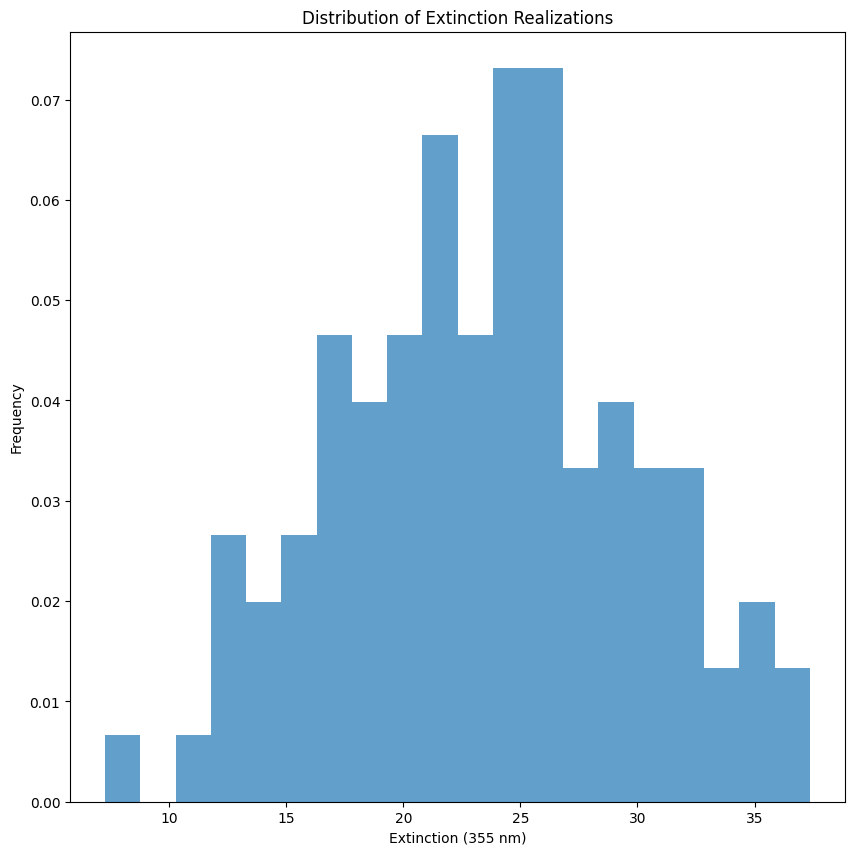

In [3]:
directory = '/Users/dada/Desktop/TFM/EARLINET_Database/FINAL_CASES/BCN_12_04_2024/Retrieval_Uncertainty_same_error_sphere_model'
print(f'Directory where to save results: {directory}')

################## SELECT WAVELENGTHS TO BE CONSIDERED ################## 
wavelengths_to_select = {
    'extinction' : [1,1,0],
    'backscatter' : [1,1,1],
    'particle depolarization' : [1,1,0],
} 
print(wavelengths_to_select)
################## INPUT VALUES #########################################
ext_355 = { 
    'value' : 23.198,
    'error' : 0.2690,
}
ext_532 = {
    'value' : 27.618,
    'error' : 0.2970,
}
back_355 = {
    'value' : 0.52973,
    'error' : 0.0613,
}
back_532 = {
    'value' : 0.58056,
    'error' : 0.0455,
}
back_1064 = {
    'value' : 0.36536,
    'error' : 0.2049,
}
pd_355 = {
    'value' : 0.3710,
    'error' : 0.2259,
}
pd_532 = {
    'value' : 0.4365,
    'error' : 0.1199,
}
################## GENERATE REALIZATIONS ################################
n = 100  
np.random.seed(0)
ext_355_realizations = np.random.normal(loc=ext_355['value'] , scale=ext_355['error']*ext_355['value'] , size=n)
ext_532_realizations = np.random.normal(loc=ext_532['value'] , scale=ext_532['error']*ext_532['value'] , size=n)
back_355_realizations = np.random.normal(loc=back_355['value'], scale=back_355['error']*back_355['value'], size=n)
back_532_realizations = np.random.normal(loc=back_532['value'], scale=back_532['error']*back_532['value'], size=n)
back_1064_realizations = np.random.normal(loc=back_1064['value'], scale=back_1064['error']*back_1064['value'], size=n)

pd_355_realizations = np.random.normal(loc=pd_355['value'] , scale=pd_355['error']*pd_355['value'] , size=n)
pd_532_realizations = np.random.normal(loc=pd_532['value'] , scale=pd_532['error']*pd_532['value'] , size=n)

figure = plt.figure(figsize=(10,10))
plt.hist(ext_355_realizations, bins=20, density=True, alpha=0.7)
plt.xlabel('Extinction (355 nm)')
plt.ylabel('Frequency')
plt.title('Distribution of Extinction Realizations')
plt.show()

In [ ]:
ext_355_realizations

## Main 

In [4]:
##### FIRST REALIZATION ####
extinction = {
    'value' : [23.198, 27.618],
    'error' : [0.1, 0.1],
    # 'error' : [0.2690, 0.2970],
}
backscatter = {
    'value' : [0.52973, 0.58056, 0.36536],
    'error' : [0.1, 0.1, 0.1],
    # 'error' : [0.0613, 0.0455, 0.2049],
}
particle_depolarization = {
    'value' : [0.3710, 0.4365],
    'error' : [0.1, 0.1],
    # 'error' : [0.2259, 0.1199],
}

driver = webdriver.Chrome(options=chrome_options)
# driver = webdriver.Chrome()
driver.get("https://boreal.loa.univ-lille.fr/")
utils.press_button(driver,'clear') # Clear input parameters
# utils.press_button(driver,'debug') # Allow debug

################## INSERTING INPUT PARAMETERS #########################################
# Select aerosol type
utils.select_aerosol_type(driver, 'dust') 
# Select particle shape model
utils.select_particle_shape_model(driver, 'sphere') 
# Select wavlengths 
utils.select_wavelengths(driver, wavelengths_to_select)
# Insert extinctions
utils.input_extinction(driver, extinction)
# Insert backscatters
utils.input_backscatter(driver, backscatter)
# Insert particle depolarization ratios
utils.input_pd(driver, particle_depolarization)
################### STARTING INVERSION ##########################################
utils.press_button(driver,'submit')
# time.sleep(60) 
WebDriverWait(driver, 300).until(EC.visibility_of_element_located((By.XPATH, "//pre[contains(text(), 'Finished the inversion at')]")))
################### SAVING RESULTS ##############################################
output_link = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.PARTIAL_LINK_TEXT, "Output results in text format")))
output_link.click()
time.sleep(2)
driver.switch_to.window(driver.window_handles[1])
full_text_content = driver.find_element(By.TAG_NAME,'body').text

# Save the extracted part to a file
if not os.path.exists(directory):
    os.makedirs(directory)
# file_path = os.path.join(directory, 'Case01_110_111_110.txt')
file_path = os.path.join(directory, f'Realization_01.txt')
with open(file_path, 'w') as file:
    file.write(full_text_content)

driver.close()
driver.switch_to.window(driver.window_handles[0])

## 100 RANDOM REALIZATIONS 

In [5]:
for i in tqdm(range(n), desc='100 realizations'):
    utils.press_button(driver,'clear') # Clear input parameters
    extinction = {
    'value' : [ext_355_realizations[i], ext_532_realizations[i]],
    # 'error' : [0.2690, 0.2970],
    'error' : [0.1, 0.1]
    }
    backscatter = {
        'value' : [back_355_realizations[i], back_532_realizations[i], back_1064_realizations[i]],
        # 'error' : [0.0613, 0.0455, 0.2049],
        'error' : [0.1, 0.1, 0.1]
    }
    particle_depolarization = {
        'value' : [pd_355_realizations[i], pd_355_realizations[i]],
        # 'error' : [0.2259, 0.1199],
        'error' : [0.1, 0.1]
    }
    print(f'Realization: {i+2}')

    print(f'Starting with input parameters:')
    print(f'Extinctions: {extinction}')
    print(f'Backscatter: {backscatter}')
    print(f'Particle depolarizations: {particle_depolarization}')
    time.sleep(120)
    # Select wavlengths 
    utils.select_wavelengths(driver, wavelengths_to_select)
    # Insert extinctions
    utils.input_extinction(driver, extinction)
    # Insert backscatters
    utils.input_backscatter(driver, backscatter)
    # Insert particle depolarization ratios
    utils.input_pd(driver, particle_depolarization)
    ################### STARTING INVERSION ##########################################
    utils.press_button(driver,'submit') 
    WebDriverWait(driver, 300).until(EC.visibility_of_element_located((By.XPATH, "//pre[contains(text(), 'Finished the inversion at')]")))
    ################### SAVING RESULTS ##############################################
    time.sleep(60)
    output_link = WebDriverWait(driver, 50).until(EC.element_to_be_clickable((By.PARTIAL_LINK_TEXT, "Output results in text format")))
    output_link.click()
    time.sleep(2)
    driver.switch_to.window(driver.window_handles[1])
    full_text_content = driver.find_element(By.TAG_NAME,'body').text
    if not os.path.exists(directory):
            os.makedirs(directory)
    filename = f'{directory}/Realization_{i+2}.txt'

    # Save the extracted part to a file
    with open(filename, 'w') as file:
        file.write(full_text_content)

    driver.close()
    driver.switch_to.window(driver.window_handles[0])

driver.quit()


100 realizations:   0%|          | 0/100 [00:00<?, ?it/s]

Realization: 2
Starting with input parameters:
Extinctions: {'value': [34.20614882055287, 43.06463021753599], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5177417615956877, 0.5460474660785227, 0.32054341092943206], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4030763839536552, 0.4030763839536552], 'error': [0.1, 0.1]}


100 realizations:   1%|          | 1/100 [03:32<5:51:17, 212.90s/it]

Realization: 3
Starting with input parameters:
Extinctions: {'value': [25.695085821400067, 16.56294430406227], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5219567718645038, 0.6243603178048406, 0.2818214252402287], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.36813019213512554, 0.36813019213512554], 'error': [0.1, 0.1]}


100 realizations:   2%|▏         | 2/100 [07:08<5:50:18, 214.47s/it]

Realization: 4
Starting with input parameters:
Extinctions: {'value': [29.30558145017165, 17.19678835761084], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5654386401448049, 0.5774386400291871, 0.4227541415033944], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.46288362315372034, 0.46288362315372034], 'error': [0.1, 0.1]}


100 realizations:   3%|▎         | 3/100 [10:43<5:46:58, 214.62s/it]

Realization: 5
Starting with input parameters:
Extinctions: {'value': [37.181760677035285, 35.56952109091466], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5510080180774394, 0.5625927662558853, 0.39203288696291433], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3513706313266959, 0.3513706313266959], 'error': [0.1, 0.1]}


100 realizations:   4%|▍         | 4/100 [14:13<5:40:30, 212.81s/it]

Realization: 6
Starting with input parameters:
Extinctions: {'value': [34.85205115872922, 17.995401305874466], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5505166383344963, 0.5981628289757523, 0.23296320761126516], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3418805430098132, 0.3418805430098132], 'error': [0.1, 0.1]}


100 realizations:   5%|▌         | 5/100 [17:45<5:36:40, 212.63s/it]

Realization: 7
Starting with input parameters:
Extinctions: {'value': [17.09952998276667, 43.56064218186286], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4772234773158747, 0.5683898656706334, 0.39197217181557736], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3222845283496607, 0.3222845283496607], 'error': [0.1, 0.1]}


100 realizations:   6%|▌         | 6/100 [21:20<5:34:34, 213.56s/it]

Realization: 8
Starting with input parameters:
Extinctions: {'value': [29.12680064852507, 24.225271283845057], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.528940071166088, 0.5453149220338299, 0.4263367979843198], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.23417069625426581, 0.23417069625426581], 'error': [0.1, 0.1]}


100 realizations:   7%|▋         | 7/100 [24:42<5:24:51, 209.58s/it]

Realization: 9
Starting with input parameters:
Extinctions: {'value': [22.253491364633792, 21.48696752623586], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5057643289403947, 0.5449858106599548, 0.3697713030136707], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.23960711157020523, 0.23960711157020523], 'error': [0.1, 0.1]}


100 realizations:   8%|▊         | 8/100 [28:02<5:16:48, 206.61s/it]

Realization: 10
Starting with input parameters:
Extinctions: {'value': [22.55388732146903, 43.39102042753857], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.538819837266277, 0.5988863508394231, 0.35150646322672957], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.2721760709069791, 0.2721760709069791], 'error': [0.1, 0.1]}


100 realizations:   9%|▉         | 9/100 [31:34<5:16:03, 208.39s/it]

Realization: 11
Starting with input parameters:
Extinctions: {'value': [25.760242228902953, 39.76199068042127], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.526542816477989, 0.576344791036116, 0.30489760570086366], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.48007125511534476, 0.48007125511534476], 'error': [0.1, 0.1]}


100 realizations:  10%|█         | 10/100 [35:06<5:14:17, 209.53s/it]

Realization: 12
Starting with input parameters:
Extinctions: {'value': [24.096869623459522, 42.93673828061112], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5592857381739124, 0.5770282091246095, 0.25706913743612503], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.44603077868460483, 0.44603077868460483], 'error': [0.1, 0.1]}


100 realizations:  11%|█         | 11/100 [38:38<5:11:54, 210.28s/it]

Realization: 13
Starting with input parameters:
Extinctions: {'value': [32.27304770310779, 35.049872987558125], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5400308523146706, 0.6090291199518898, 0.4252721163621518], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4862342259439234, 0.4862342259439234], 'error': [0.1, 0.1]}


100 realizations:  12%|█▏        | 12/100 [42:10<5:09:09, 210.79s/it]

Realization: 14
Starting with input parameters:
Extinctions: {'value': [27.94707479680123, 20.55375670195729], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5552639946468577, 0.5507943553853024, 0.3422189928292869], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.25934880666125487, 0.25934880666125487], 'error': [0.1, 0.1]}


100 realizations:  13%|█▎        | 13/100 [45:42<5:06:07, 211.12s/it]

Realization: 15
Starting with input parameters:
Extinctions: {'value': [23.95728398176957, 43.28539564078267], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5145842296686161, 0.5612587964327542, 0.34788215714831744], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.20601173023619243, 0.20601173023619243], 'error': [0.1, 0.1]}


100 realizations:  14%|█▍        | 14/100 [49:14<5:02:59, 211.39s/it]

Realization: 16
Starting with input parameters:
Extinctions: {'value': [25.967822864498437, 25.419690021616237], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4990615171214537, 0.5703932150981682, 0.4950754309335335], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.31568140587151466, 0.31568140587151466], 'error': [0.1, 0.1]}


100 realizations:  15%|█▌        | 15/100 [52:42<4:57:57, 210.32s/it]

Realization: 17
Starting with input parameters:
Extinctions: {'value': [25.280215225489197, 34.200185499514134], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5164146822500146, 0.5830523425205734, 0.41660330256998496], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.38573519307489146, 0.38573519307489146], 'error': [0.1, 0.1]}


100 realizations:  16%|█▌        | 16/100 [56:14<4:55:15, 210.90s/it]

Realization: 18
Starting with input parameters:
Extinctions: {'value': [32.52144486522063, 35.387877839254685], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5291773054789255, 0.5794460208718627, 0.39312079914370623], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4127946833808902, 0.4127946833808902], 'error': [0.1, 0.1]}


100 realizations:  17%|█▋        | 17/100 [59:48<4:52:39, 211.56s/it]

Realization: 19
Starting with input parameters:
Extinctions: {'value': [21.917758682636297, 26.346522580958148], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.542041985396074, 0.5729817371071682, 0.3759950683642434], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4588293936223109, 0.4588293936223109], 'error': [0.1, 0.1]}


100 realizations:  18%|█▊        | 18/100 [1:03:20<4:49:38, 211.93s/it]

Realization: 20
Starting with input parameters:
Extinctions: {'value': [25.15162448203946, 32.655014282914756], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.6030952946765522, 0.5789321090079704, 0.47915025654529053], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.39482516650271476, 0.39482516650271476], 'error': [0.1, 0.1]}


100 realizations:  19%|█▉        | 19/100 [1:06:54<4:46:43, 212.39s/it]

Realization: 21
Starting with input parameters:
Extinctions: {'value': [17.86821881367354, 35.18244264503133], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5283578067978145, 0.577725479620236, 0.4940923487033683], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.5170511535710898, 0.5170511535710898], 'error': [0.1, 0.1]}


100 realizations:  20%|██        | 20/100 [1:10:27<4:43:21, 212.52s/it]

Realization: 22
Starting with input parameters:
Extinctions: {'value': [7.266674665863599, 30.705647734878482], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.49868812472469337, 0.5615513046662979, 0.4349448570449299], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3523436627459703, 0.3523436627459703], 'error': [0.1, 0.1]}


100 realizations:  21%|██        | 21/100 [1:13:59<4:39:51, 212.56s/it]

Realization: 23
Starting with input parameters:
Extinctions: {'value': [27.276751283619856, 18.600114442796777], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5184951244336723, 0.5590843999707095, 0.40894665106852357], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.29447583512305686, 0.29447583512305686], 'error': [0.1, 0.1]}


100 realizations:  22%|██▏       | 22/100 [1:17:32<4:36:31, 212.71s/it]

Realization: 24
Starting with input parameters:
Extinctions: {'value': [28.59230836316742, 30.064312342881188], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5146759033566994, 0.5878114813571296, 0.2085532719081548], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.23009895069944858, 0.23009895069944858], 'error': [0.1, 0.1]}


100 realizations:  23%|██▎       | 23/100 [1:21:06<4:33:14, 212.91s/it]

Realization: 25
Starting with input parameters:
Extinctions: {'value': [18.566695825428454, 38.49774133132661], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5453648826015536, 0.5570260504434332, 0.37462210260593415], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.29649628834651426, 0.29649628834651426], 'error': [0.1, 0.1]}


100 realizations:  24%|██▍       | 24/100 [1:24:39<4:29:50, 213.03s/it]

Realization: 26
Starting with input parameters:
Extinctions: {'value': [37.36186352939416, 21.920775180431924], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4796965475290947, 0.5499879052979492, 0.35561989884691503], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.39129163998040606, 0.39129163998040606], 'error': [0.1, 0.1]}


100 realizations:  25%|██▌       | 25/100 [1:28:12<4:26:23, 213.12s/it]

Realization: 27
Starting with input parameters:
Extinctions: {'value': [14.122377146696962, 26.390615799773425], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5317842718803086, 0.5723106502862343, 0.372393551461915], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.2965173328234753, 0.2965173328234753], 'error': [0.1, 0.1]}


100 realizations:  26%|██▌       | 26/100 [1:31:45<4:22:45, 213.05s/it]

Realization: 28
Starting with input parameters:
Extinctions: {'value': [23.483545136692555, 24.04863297493989], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5348121505722473, 0.576395150087865, 0.4359585651533054], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.44950735545218, 0.44950735545218], 'error': [0.1, 0.1]}


100 realizations:  27%|██▋       | 27/100 [1:35:18<4:19:11, 213.03s/it]

Realization: 29
Starting with input parameters:
Extinctions: {'value': [22.029923733670092, 42.78667079898331], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5372694868567807, 0.6401724344084109, 0.16026156463508331], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.48936563148252143, 0.48936563148252143], 'error': [0.1, 0.1]}


100 realizations:  28%|██▊       | 28/100 [1:38:51<4:15:35, 212.99s/it]

Realization: 30
Starting with input parameters:
Extinctions: {'value': [32.762943885750936, 33.132528669953324], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5103336844136418, 0.5619450039571251, 0.3227400107547329], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.17240752801855416, 0.17240752801855416], 'error': [0.1, 0.1]}


100 realizations:  29%|██▉       | 29/100 [1:42:24<4:12:05, 213.04s/it]

Realization: 31
Starting with input parameters:
Extinctions: {'value': [32.367183696175495, 30.960224455012174], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5220040987651557, 0.6054766848152171, 0.385565651074325], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4434152728471773, 0.4434152728471773], 'error': [0.1, 0.1]}


100 realizations:  30%|███       | 30/100 [1:45:57<4:08:30, 213.01s/it]

Realization: 32
Starting with input parameters:
Extinctions: {'value': [24.16491253257429, 21.302727983222866], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4834872547601711, 0.6002973384984157, 0.33041088548417397], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.1833012474080244, 0.1833012474080244], 'error': [0.1, 0.1]}


100 realizations:  31%|███       | 31/100 [1:49:28<4:04:13, 212.37s/it]

Realization: 33
Starting with input parameters:
Extinctions: {'value': [25.5578332008977, 32.04121629703393], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5137106952468352, 0.5491534483147148, 0.2592872004959281], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40464919415815637, 0.40464919415815637], 'error': [0.1, 0.1]}


100 realizations:  32%|███▏      | 32/100 [1:53:01<4:00:44, 212.42s/it]

Realization: 34
Starting with input parameters:
Extinctions: {'value': [17.65798433492222, 22.086755331655482], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5121019584059825, 0.6009858485595188, 0.43041257396242844], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.47365505462745, 0.47365505462745], 'error': [0.1, 0.1]}


100 realizations:  33%|███▎      | 33/100 [1:56:34<3:57:24, 212.60s/it]

Realization: 35
Starting with input parameters:
Extinctions: {'value': [10.83731106960802, 27.879091618451046], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5432401639086718, 0.5492872246265862, 0.386087257709636], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.37643551893093813, 0.37643551893093813], 'error': [0.1, 0.1]}


100 realizations:  34%|███▍      | 34/100 [2:00:07<3:54:00, 212.73s/it]

Realization: 36
Starting with input parameters:
Extinctions: {'value': [21.026937035221685, 22.402443293177623], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.492185924947967, 0.5103166889306419, 0.2926609132757784], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.2637506580518432, 0.2637506580518432], 'error': [0.1, 0.1]}


100 realizations:  35%|███▌      | 35/100 [2:03:40<3:50:34, 212.84s/it]

Realization: 37
Starting with input parameters:
Extinctions: {'value': [24.17365853063874, 33.16647521773023], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5550974155166746, 0.5965762212693247, 0.3889279286762056], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3219356547438046, 0.3219356547438046], 'error': [0.1, 0.1]}


100 realizations:  36%|███▌      | 36/100 [2:07:16<3:48:07, 213.87s/it]

Realization: 38
Starting with input parameters:
Extinctions: {'value': [30.87533618389933, 32.347512696461614], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5782595731522843, 0.5341773074110125, 0.4268657664740998], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.34907178300495967, 0.34907178300495967], 'error': [0.1, 0.1]}


100 realizations:  37%|███▋      | 37/100 [2:10:52<3:45:06, 214.39s/it]

Realization: 39
Starting with input parameters:
Extinctions: {'value': [30.701165279935108, 25.90941987562874], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.46251251684448436, 0.5924716502571449, 0.3657562194845214], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.355726265139827, 0.355726265139827], 'error': [0.1, 0.1]}


100 realizations:  38%|███▊      | 38/100 [2:14:27<3:41:57, 214.80s/it]

Realization: 40
Starting with input parameters:
Extinctions: {'value': [20.78097917974822, 30.866263276915927], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5435716648959966, 0.5624915238110405, 0.4252920936635594], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.35399543896187047, 0.35399543896187047], 'error': [0.1, 0.1]}


100 realizations:  39%|███▉      | 39/100 [2:18:04<3:38:49, 215.23s/it]

Realization: 41
Starting with input parameters:
Extinctions: {'value': [21.311551633089255, 18.652112693808625], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5517108616452099, 0.6243978308657376, 0.3712187338936386], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.36179084513714366, 0.36179084513714366], 'error': [0.1, 0.1]}


100 realizations:  40%|████      | 40/100 [2:21:40<3:35:30, 215.51s/it]

Realization: 42
Starting with input parameters:
Extinctions: {'value': [16.654754777104493, 15.385890997983005], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5090308586970436, 0.608785188667444, 0.33577226356007833], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.38889152807110744, 0.38889152807110744], 'error': [0.1, 0.1]}


100 realizations:  41%|████      | 41/100 [2:25:16<3:32:06, 215.71s/it]

Realization: 43
Starting with input parameters:
Extinctions: {'value': [14.336716027303654, 31.22213064164062], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5168296112700707, 0.5685835963660797, 0.2785631552142534], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.26971077151163786, 0.26971077151163786], 'error': [0.1, 0.1]}


100 realizations:  42%|████▏     | 42/100 [2:28:48<3:27:34, 214.73s/it]

Realization: 44
Starting with input parameters:
Extinctions: {'value': [12.550426967709978, 28.985147012773954], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.525415042221217, 0.562390439342624, 0.35892702823724865], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.35071658428038976, 0.35071658428038976], 'error': [0.1, 0.1]}


100 realizations:  43%|████▎     | 43/100 [2:32:21<3:23:22, 214.08s/it]

Realization: 45
Starting with input parameters:
Extinctions: {'value': [35.37134956939992, 32.8268745725536], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5200600008559623, 0.5484895626401153, 0.3799052092213182], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4982437986002243, 0.4982437986002243], 'error': [0.1, 0.1]}


100 realizations:  44%|████▍     | 44/100 [2:35:54<3:19:22, 213.62s/it]

Realization: 46
Starting with input parameters:
Extinctions: {'value': [20.017636856998063, 47.16585464048113], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5196955921222788, 0.5689128170251276, 0.43092682341779986], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.33876329019639106, 0.33876329019639106], 'error': [0.1, 0.1]}


100 realizations:  45%|████▌     | 45/100 [2:39:26<3:15:38, 213.42s/it]

Realization: 47
Starting with input parameters:
Extinctions: {'value': [20.464301582479173, 35.36513643809527], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.47530605187514396, 0.5731542750240635, 0.3567427943057376], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.33380258525236534, 0.33380258525236534], 'error': [0.1, 0.1]}


100 realizations:  46%|████▌     | 46/100 [2:43:00<3:12:00, 213.34s/it]

Realization: 48
Starting with input parameters:
Extinctions: {'value': [15.380228720904128, 20.130533705971917], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5671490279685101, 0.5709264449719923, 0.3996031678706359], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4613625300072562, 0.4613625300072562], 'error': [0.1, 0.1]}


100 realizations:  47%|████▋     | 47/100 [2:46:33<3:08:22, 213.26s/it]

Realization: 49
Starting with input parameters:
Extinctions: {'value': [28.049743522864347, 36.78037748585548], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5647878596693675, 0.58469940755487, 0.293146960770294], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.15651754821683428, 0.15651754821683428], 'error': [0.1, 0.1]}


100 realizations:  48%|████▊     | 48/100 [2:50:06<3:04:45, 213.19s/it]

Realization: 50
Starting with input parameters:
Extinctions: {'value': [13.126854590002322, 16.824208933538365], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5033180705745688, 0.5958419230528272, 0.3067706095223427], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4700100410575098, 0.4700100410575098], 'error': [0.1, 0.1]}


100 realizations:  49%|████▉     | 49/100 [2:53:38<3:01:01, 212.96s/it]

Realization: 51
Starting with input parameters:
Extinctions: {'value': [21.87044491351142, 23.831831046115525], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.48211161080307363, 0.589796290315614, 0.3570960071534742], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.31804084113572073, 0.31804084113572073], 'error': [0.1, 0.1]}


100 realizations:  50%|█████     | 50/100 [2:57:10<2:57:18, 212.78s/it]

Realization: 52
Starting with input parameters:
Extinctions: {'value': [17.61005404591243, 27.058245093210864], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5466502526263035, 0.5603747714609278, 0.28640812550723943], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.38473867333582157, 0.38473867333582157], 'error': [0.1, 0.1]}


100 realizations:  51%|█████     | 51/100 [3:00:43<2:53:40, 212.67s/it]

Realization: 53
Starting with input parameters:
Extinctions: {'value': [25.612372955096234, 41.67177248809412], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5110327545154317, 0.5425800480796239, 0.42676561014322933], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.379072586886264, 0.379072586886264], 'error': [0.1, 0.1]}


100 realizations:  52%|█████▏    | 52/100 [3:04:15<2:50:04, 212.60s/it]

Realization: 54
Starting with input parameters:
Extinctions: {'value': [20.01044211062419, 21.509114313425854], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5343395668563227, 0.6166047637429138, 0.4000309849798565], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.44998721635693006, 0.44998721635693006], 'error': [0.1, 0.1]}


100 realizations:  53%|█████▎    | 53/100 [3:07:48<2:46:36, 212.69s/it]

Realization: 55
Starting with input parameters:
Extinctions: {'value': [15.830545845443908, 20.839099870476655], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5193606242600052, 0.5623478688545048, 0.38625374079522967], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.34857317867223636, 0.34857317867223636], 'error': [0.1, 0.1]}


100 realizations:  54%|█████▍    | 54/100 [3:11:21<2:43:00, 212.62s/it]

Realization: 56
Starting with input parameters:
Extinctions: {'value': [23.02213551142297, 26.810438639584266], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5521859568256504, 0.5633293514567884, 0.39073113009260513], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3141754050754431, 0.3141754050754431], 'error': [0.1, 0.1]}


100 realizations:  55%|█████▌    | 55/100 [3:14:42<2:36:59, 209.33s/it]

Realization: 57
Starting with input parameters:
Extinctions: {'value': [25.870903095059887, 22.17578883611364], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5522902061351633, 0.5667925341446962, 0.5166598966553752], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4797710280840989, 0.4797710280840989], 'error': [0.1, 0.1]}


100 realizations:  56%|█████▌    | 56/100 [3:18:16<2:34:24, 210.56s/it]

Realization: 58
Starting with input parameters:
Extinctions: {'value': [23.61308489518323, 36.85928297633104], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5061680761333076, 0.531874433159228, 0.3302597653802841], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.17286119297659655, 0.17286119297659655], 'error': [0.1, 0.1]}


100 realizations:  57%|█████▋    | 57/100 [3:21:49<2:31:26, 211.32s/it]

Realization: 59
Starting with input parameters:
Extinctions: {'value': [25.085503889533445, 18.759812125799634], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4848087845099958, 0.5679340872557486, 0.2005551213043579], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.37270418540111655, 0.37270418540111655], 'error': [0.1, 0.1]}


100 realizations:  58%|█████▊    | 58/100 [3:25:21<2:28:10, 211.68s/it]

Realization: 60
Starting with input parameters:
Extinctions: {'value': [19.239663943042242, 18.20583559503992], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.47832811362239486, 0.5678896614381893, 0.38028006395531516], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.2580318530474183, 0.2580318530474183], 'error': [0.1, 0.1]}


100 realizations:  59%|█████▉    | 59/100 [3:28:48<2:23:38, 210.21s/it]

Realization: 61
Starting with input parameters:
Extinctions: {'value': [20.93440008605477, 24.02676094326172], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5495505132587104, 0.5969470622227271, 0.361571704357193], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.30717337206094486, 0.30717337206094486], 'error': [0.1, 0.1]}


100 realizations:  60%|██████    | 60/100 [3:32:10<2:18:32, 207.81s/it]

Realization: 62
Starting with input parameters:
Extinctions: {'value': [19.00167062124075, 23.532865913703635], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4911248283834303, 0.5990100808531018, 0.326617352814559], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.5395612100910758, 0.5395612100910758], 'error': [0.1, 0.1]}


100 realizations:  61%|██████    | 61/100 [3:35:43<2:16:06, 209.39s/it]

Realization: 63
Starting with input parameters:
Extinctions: {'value': [20.954294069058697, 43.4450754299083], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.51327243178267, 0.5806596098452406, 0.2920825806576009], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3672625063637037, 0.3672625063637037], 'error': [0.1, 0.1]}


100 realizations:  62%|██████▏   | 62/100 [3:39:16<2:13:12, 210.34s/it]

Realization: 64
Starting with input parameters:
Extinctions: {'value': [18.12375415571671, 35.40566784216567], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5103662227984319, 0.6051752220894488, 0.33248127807281386], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3873485767415904, 0.3873485767415904], 'error': [0.1, 0.1]}


100 realizations:  63%|██████▎   | 63/100 [3:42:49<2:10:07, 211.02s/it]

Realization: 65
Starting with input parameters:
Extinctions: {'value': [12.425544275408525, 28.33614308481913], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5280230111528194, 0.5895403382303025, 0.3789354053614499], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.22168917678245567, 0.22168917678245567], 'error': [0.1, 0.1]}


100 realizations:  64%|██████▍   | 64/100 [3:46:19<2:06:26, 210.73s/it]

Realization: 66
Starting with input parameters:
Extinctions: {'value': [24.305185613312688, 17.56630878676168], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.46685425275491943, 0.580145749494605, 0.32771800341288937], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3098995690955412, 0.3098995690955412], 'error': [0.1, 0.1]}


100 realizations:  65%|██████▌   | 65/100 [3:49:52<2:03:18, 211.39s/it]

Realization: 67
Starting with input parameters:
Extinctions: {'value': [20.69078169145516, 34.543926154630604], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5358601033566792, 0.5848109948111183, 0.5459617442457755], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3874732595419387, 0.3874732595419387], 'error': [0.1, 0.1]}


100 realizations:  66%|██████▌   | 66/100 [3:53:24<1:59:58, 211.72s/it]

Realization: 68
Starting with input parameters:
Extinctions: {'value': [13.025135202964977, 19.413687603131116], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.546742024553014, 0.5755237964533704, 0.29345446740902253], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40073185202635636, 0.40073185202635636], 'error': [0.1, 0.1]}


100 realizations:  67%|██████▋   | 67/100 [3:56:56<1:56:28, 211.77s/it]

Realization: 69
Starting with input parameters:
Extinctions: {'value': [26.085882523431778, 14.946944019211188], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5326012817120314, 0.5701298605590397, 0.30598543860999455], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4227005835484908, 0.4227005835484908], 'error': [0.1, 0.1]}


100 realizations:  68%|██████▊   | 68/100 [4:00:28<1:53:02, 211.97s/it]

Realization: 70
Starting with input parameters:
Extinctions: {'value': [17.5362204940771, 37.3628690211402], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5196347646447161, 0.5734876901108481, 0.19402872236874183], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.37172309471759324, 0.37172309471759324], 'error': [0.1, 0.1]}


100 realizations:  69%|██████▉   | 69/100 [4:04:01<1:49:36, 212.14s/it]

Realization: 71
Starting with input parameters:
Extinctions: {'value': [23.522152879461608, 30.217736353673725], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5328928219317546, 0.5507630392337807, 0.3841866926692279], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4151676430059557, 0.4151676430059557], 'error': [0.1, 0.1]}


100 realizations:  70%|███████   | 70/100 [4:07:33<1:46:06, 212.22s/it]

Realization: 72
Starting with input parameters:
Extinctions: {'value': [27.747716129715123, 35.17138686156806], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5426880121074356, 0.5879680022579484, 0.21440723469830464], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40903096293789276, 0.40903096293789276], 'error': [0.1, 0.1]}


100 realizations:  71%|███████   | 71/100 [4:11:06<1:42:37, 212.32s/it]

Realization: 73
Starting with input parameters:
Extinctions: {'value': [24.00288715664886, 30.232378234737165], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.4396971231191662, 0.5543261631179619, 0.3249752048202949], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.21765146886816233, 0.21765146886816233], 'error': [0.1, 0.1]}


100 realizations:  72%|███████▏  | 72/100 [4:14:38<1:39:06, 212.38s/it]

Realization: 74
Starting with input parameters:
Extinctions: {'value': [30.308158794529547, 34.64619250833997], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.593243262678143, 0.6027920938235118, 0.3447226796647065], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.37410140884699555, 0.37410140884699555], 'error': [0.1, 0.1]}


100 realizations:  73%|███████▎  | 73/100 [4:18:06<1:34:57, 211.03s/it]

Realization: 75
Starting with input parameters:
Extinctions: {'value': [15.492363356628275, 22.277932623778252], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5423972855262242, 0.57397043186493, 0.31222815765258727], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4353570560994294, 0.4353570560994294], 'error': [0.1, 0.1]}


100 realizations:  74%|███████▍  | 74/100 [4:21:39<1:31:38, 211.50s/it]

Realization: 76
Starting with input parameters:
Extinctions: {'value': [25.708717254457895, 19.134575515092205], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5085446955812752, 0.5818674336978783, 0.4955359454419864], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4204371789079573, 0.4204371789079573], 'error': [0.1, 0.1]}


100 realizations:  75%|███████▌  | 75/100 [4:25:15<1:28:38, 212.76s/it]

Realization: 77
Starting with input parameters:
Extinctions: {'value': [18.92460561228862, 33.20881038955289], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5170347864628428, 0.593604935487114, 0.4398026154427802], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3405053933810391, 0.3405053933810391], 'error': [0.1, 0.1]}


100 realizations:  76%|███████▌  | 76/100 [4:28:50<1:25:27, 213.63s/it]

Realization: 78
Starting with input parameters:
Extinctions: {'value': [17.763997640251972, 21.027995272769516], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.545763004684141, 0.5975534603855804, 0.4641135730858239], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3034813285922839, 0.3034813285922839], 'error': [0.1, 0.1]}


100 realizations:  77%|███████▋  | 77/100 [4:32:26<1:22:07, 214.25s/it]

Realization: 79
Starting with input parameters:
Extinctions: {'value': [19.58582643325788, 21.9619362287142], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5259598207610074, 0.5390712287617112, 0.2993001294471479], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.27727550776572074, 0.27727550776572074], 'error': [0.1, 0.1]}


100 realizations:  78%|███████▊  | 78/100 [4:35:55<1:18:02, 212.84s/it]

Realization: 80
Starting with input parameters:
Extinctions: {'value': [21.25383057276178, 23.88147368540383], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.46378870218487334, 0.5750945400803641, 0.4498491068065227], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.36001650745212693, 0.36001650745212693], 'error': [0.1, 0.1]}


100 realizations:  79%|███████▉  | 79/100 [4:39:28<1:14:28, 212.81s/it]

Realization: 81
Starting with input parameters:
Extinctions: {'value': [23.548486450833277, 27.761373605944343], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5967691391513545, 0.6038103484484916, 0.40249175378945157], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.46596217831803277, 0.46596217831803277], 'error': [0.1, 0.1]}


100 realizations:  80%|████████  | 80/100 [4:43:01<1:10:57, 212.87s/it]

Realization: 82
Starting with input parameters:
Extinctions: {'value': [15.92715972425357, 24.71434865922338], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5261404741455921, 0.5357037196889036, 0.42310919578101647], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.20742144523933856, 0.20742144523933856], 'error': [0.1, 0.1]}


100 realizations:  81%|████████  | 81/100 [4:46:30<1:06:59, 211.55s/it]

Realization: 83
Starting with input parameters:
Extinctions: {'value': [28.81939329513371, 16.3398987679792], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5628575063523831, 0.5907901996521887, 0.44242612137218634], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.31569520001227347, 0.31569520001227347], 'error': [0.1, 0.1]}


100 realizations:  82%|████████▏ | 82/100 [4:49:56<1:02:57, 209.86s/it]

Realization: 84
Starting with input parameters:
Extinctions: {'value': [26.10385562747728, 22.338690444316683], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5072574466123636, 0.520978188209511, 0.29732792596751645], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.275474409993383, 0.275474409993383], 'error': [0.1, 0.1]}


100 realizations:  83%|████████▎ | 83/100 [4:53:21<59:05, 208.53s/it]  

Realization: 85
Starting with input parameters:
Extinctions: {'value': [13.61143690178432, 9.380433367334138], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.579619925538767, 0.5535499909220806, 0.33359462223850045], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4367864264018929, 0.4367864264018929], 'error': [0.1, 0.1]}


100 realizations:  84%|████████▍ | 84/100 [4:56:44<55:10, 206.92s/it]

Realization: 86
Starting with input parameters:
Extinctions: {'value': [32.485083611359315, 32.74648973769725], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5390282808340264, 0.5815804445695234, 0.4299358903254175], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.32454391993764853, 0.32454391993764853], 'error': [0.1, 0.1]}


100 realizations:  85%|████████▌ | 85/100 [5:00:01<50:58, 203.91s/it]

Realization: 87
Starting with input parameters:
Extinctions: {'value': [35.028845181394956, 14.477048385233493], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5495006503639686, 0.5367970753489164, 0.16655434237827005], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3315563755714709, 0.3315563755714709], 'error': [0.1, 0.1]}


100 realizations:  86%|████████▌ | 86/100 [5:03:32<48:06, 206.15s/it]

Realization: 88
Starting with input parameters:
Extinctions: {'value': [30.553893364283866, 18.559244856704517], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.49578806337571474, 0.554527260818919, 0.4786511664362091], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3528176951881364, 0.3528176951881364], 'error': [0.1, 0.1]}


100 realizations:  87%|████████▋ | 87/100 [5:07:04<45:02, 207.90s/it]

Realization: 89
Starting with input parameters:
Extinctions: {'value': [22.075221884223946, 28.04588646223179], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5690588536508118, 0.5416807717970458, 0.40676871861757313], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40832791842491695, 0.40832791842491695], 'error': [0.1, 0.1]}


100 realizations:  88%|████████▊ | 88/100 [5:10:37<41:51, 209.27s/it]

Realization: 90
Starting with input parameters:
Extinctions: {'value': [16.51622310458738, 21.55170050220242], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5521300851671296, 0.6240962753390301, 0.3619384980312079], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3381143096929769, 0.3381143096929769], 'error': [0.1, 0.1]}


100 realizations:  89%|████████▉ | 89/100 [5:14:09<38:32, 210.19s/it]

Realization: 91
Starting with input parameters:
Extinctions: {'value': [29.778055042402748, 40.27464819749514], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5720041352953917, 0.5848981549905206, 0.38186770233931466], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.11570610133457843, 0.11570610133457843], 'error': [0.1, 0.1]}


100 realizations:  90%|█████████ | 90/100 [5:17:42<35:10, 211.04s/it]

Realization: 92
Starting with input parameters:
Extinctions: {'value': [20.68207021852725, 17.013281726575563], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5093344587520044, 0.5955452449888116, 0.28825671291800864], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4165343719741075, 0.4165343719741075], 'error': [0.1, 0.1]}


100 realizations:  91%|█████████ | 91/100 [5:21:15<31:43, 211.48s/it]

Realization: 93
Starting with input parameters:
Extinctions: {'value': [30.82637751979479, 29.80849704017666], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5141098714281651, 0.5746779303358439, 0.3391624474550822], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40779570733524045, 0.40779570733524045], 'error': [0.1, 0.1]}


100 realizations:  92%|█████████▏| 92/100 [5:24:48<28:15, 211.97s/it]

Realization: 94
Starting with input parameters:
Extinctions: {'value': [24.497690431243864, 27.295780876479327], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.6045438174657902, 0.5712239307093392, 0.4477297766029189], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3526005079106922, 0.3526005079106922], 'error': [0.1, 0.1]}


100 realizations:  93%|█████████▎| 93/100 [5:28:21<24:45, 212.25s/it]

Realization: 95
Starting with input parameters:
Extinctions: {'value': [29.292483467085926, 18.03665935247693], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.49530869025748153, 0.5378600583991724, 0.4625328635700863], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.28014808326176793, 0.28014808326176793], 'error': [0.1, 0.1]}


100 realizations:  94%|█████████▍| 94/100 [5:31:51<21:10, 211.70s/it]

Realization: 96
Starting with input parameters:
Extinctions: {'value': [25.42181968636433, 31.91020087873809], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.525315380278158, 0.572850975981081, 0.5672054368261645], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.4004823041180829, 0.4004823041180829], 'error': [0.1, 0.1]}


100 realizations:  95%|█████████▌| 95/100 [5:35:24<17:40, 212.10s/it]

Realization: 97
Starting with input parameters:
Extinctions: {'value': [27.607201691687823, 26.210883327018273], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5666476467906566, 0.5604448177087342, 0.3598258321168037], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.40278331290653063, 0.40278331290653063], 'error': [0.1, 0.1]}


100 realizations:  96%|█████████▌| 96/100 [5:38:57<14:09, 212.42s/it]

Realization: 98
Starting with input parameters:
Extinctions: {'value': [23.26352288030335, 33.948647498695465], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5329033690301473, 0.6032224722636657, 0.3160592339410606], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.33160706113701066, 0.33160706113701066], 'error': [0.1, 0.1]}


100 realizations:  97%|█████████▋| 97/100 [5:42:31<10:37, 212.64s/it]

Realization: 99
Starting with input parameters:
Extinctions: {'value': [34.34229978004181, 34.37283070407859], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5486599336351512, 0.6107027535366557, 0.32686328108403356], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.3528359738556817, 0.3528359738556817], 'error': [0.1, 0.1]}


100 realizations:  98%|█████████▊| 98/100 [5:46:04<07:05, 212.79s/it]

Realization: 100
Starting with input parameters:
Extinctions: {'value': [23.989964709438876, 45.36204238282852], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5167589117691618, 0.6193003807296753, 0.28914708036918224], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.2930446066955894, 0.2930446066955894], 'error': [0.1, 0.1]}


100 realizations:  99%|█████████▉| 99/100 [5:49:37<03:32, 212.91s/it]

Realization: 101
Starting with input parameters:
Extinctions: {'value': [25.706518949108162, 38.580931985537674], 'error': [0.1, 0.1]}
Backscatter: {'value': [0.5417466209452783, 0.6030805687057994, 0.3595316167071005], 'error': [0.1, 0.1, 0.1]}
Particle depolarizations: {'value': [0.35603264464016227, 0.35603264464016227], 'error': [0.1, 0.1]}


100 realizations: 100%|██████████| 100/100 [5:53:10<00:00, 211.90s/it]


In [ ]:
driver.quit()